# Data

In [52]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [53]:
data = pd.read_csv("analysis_data/analysis_data.csv", index_col = [0])

# DO USUNIĘCIA JAK BĘDĄ POPRRAWNIE STANDARYZOWANE DANE
# OD
data["child_mortality"] = data["child_mortality"].astype(int)
data["food_supply"] -= data["food_supply"].mean()
data["food_supply"] /= data["food_supply"].std()
data["med_beds"] -= data["med_beds"].mean()
data["med_beds"] /= data["med_beds"].std()
data["co2_emission"] -= data["co2_emission"].mean()
data["co2_emission"] /= data["co2_emission"].std()
data["gender_equality"] -= data["gender_equality"].mean()
data["gender_equality"] /= data["gender_equality"].std()
# DO

data

,country,child_mortality,food_supply,med_beds,co2_emission,gender_equality
0,Afghanistan,60,-2.763008,-1.242540,-1.063447,-1.558142
1,Albania,8,0.758070,-0.284864,-0.825780,-0.052888
2,United Arab Emirates,7,0.472226,-0.857133,2.698314,-1.168484
3,Argentina,9,0.537190,0.587166,-0.324117,0.657037
4,Armenia,12,-0.159229,0.299085,-0.772411,-0.293088
...,...,...,...,...,...,...
93,Uruguay,7,0.305917,-0.537908,-0.757532,0.678388
94,United States,6,1.740333,-0.304329,1.797969,0.592984
95,Uzbekistan,20,-0.151434,0.100542,-0.629503,-0.725448
96,Vietnam,20,-0.078673,-0.374403,-0.709506,-0.164981


# Models description

Specified models use the following:

Data:
- `N`: number of observations (size of next vectors)
- `child_mortality`, `food_supply`, `med_beds`, `gender_equality`: previously presented data
<br>

Parameters:
- `alpha`: intercept parameter of the distribution
- `co2_emission_coef`, `real food_supply_coef`, `real med_beds_coef`, `real gender_equality_coef`: individual coefficients for each data
<br>

Distributions:
- `normal`: used to represent coefficient values and predictive data
- `poisson`: used to represent the predicted data

# Prior

For the coefficients priors have form: `normal_rng(0.5, 0.1)`. These are values that do not distinguish any of them and give a reasonable range of influence of these parameters and their variability. <br> <br>

For the predictive data priors have form: `normal_rng(0, 1)`. This prior expresses a lack of strong prior knowledge or preference for any particular parameter value, allowing the data to drive the estimation process. <br> <br>

For the predicted data prior have form `poisson_rng(lambda)`, where: <br>
`labda = exp(alpha + co2_emission_coef * co2_emission + food_supply_coef * food_supply + med_beds_coef * med_beds + gender_equality_coef * gender_equality)` <br>
The Poisson distribution is commonly used to model data, where the outcome represents the number of occurrences of a specific event within a fixed unit of time or space. <br>
This distribution is defined for non-negative integer values (hence the use of the exponential function) - it provides a probabilistic model that assigns higher probabilities to smaller values and decays as the values increase. This property makes it appropriate for situations where the outcome variable can only take on non-negative integer values.

In [54]:
%%writefile prior.stan

generated quantities {
  real alpha;
  real lambda;
  real child_mortality;
  real food_supply_coef;
  real co2_emission_coef;
  real gender_equality_coef;
  real med_beds_coef;
  real food_supply;
  real co2_emission;
  real med_beds;
  real gender_equality;

  food_supply_coef = normal_rng(0.5, 0.1);
  med_beds_coef = normal_rng(0.5, 0.1);
  co2_emission_coef = normal_rng(0.5, 0.1);
  gender_equality_coef = normal_rng(0.5, 0.1); 

  food_supply = normal_rng(0, 1);
  med_beds = normal_rng(0, 1);
  co2_emission = normal_rng(0, 1);
  gender_equality = normal_rng(0, 1); 

  alpha = normal_rng(2, 1);
  lambda = exp(alpha + co2_emission_coef * co2_emission + food_supply_coef * food_supply + med_beds_coef * med_beds + gender_equality_coef * gender_equality);  
  child_mortality = poisson_rng(lambda);
}

Overwriting prior.stan


In [55]:
model_prior=CmdStanModel(stan_file='prior.stan')

sim=model_prior.sample(data={}, fixed_param=True, iter_sampling=1000, iter_warmup=0, chains = 1)

INFO:cmdstanpy:compiling stan file /home/Child-Mortality-Prediction-Model/prior.stan to exe file /home/Child-Mortality-Prediction-Model/prior
INFO:cmdstanpy:compiled model executable: /home/Child-Mortality-Prediction-Model/prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [56]:
df_prior = sim.draws_pd()
df_prior

,lp__,accept_stat__,alpha,lambda,child_mortality,food_supply_coef,co2_emission_coef,gender_equality_coef,med_beds_coef,food_supply,co2_emission,med_beds,gender_equality
0,0.0,0.0,3.199780,18.575000,13.0,0.462725,0.439345,0.559423,0.581596,0.916513,0.466691,-0.897771,-0.688122
1,0.0,0.0,1.830280,0.731403,2.0,0.721821,0.449151,0.434428,0.600734,-1.836550,-2.052720,-0.161283,0.463741
2,0.0,0.0,0.847007,0.445378,0.0,0.603360,0.538488,0.518085,0.598895,-0.379972,-0.187079,-1.723510,-0.566767
3,0.0,0.0,2.112250,6.661060,8.0,0.352616,0.306557,0.553428,0.501671,0.227043,0.326872,-0.226381,-0.510761
4,0.0,0.0,1.323050,2.146430,4.0,0.419205,0.467527,0.362880,0.523582,-0.318309,-1.174260,-0.299315,0.771363
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,2.270930,9.953760,10.0,0.546043,0.527284,0.499985,0.518861,-2.090980,1.197920,-1.114520,2.230910
996,0.0,0.0,1.946470,2.759600,1.0,0.544644,0.667290,0.610661,0.693036,-0.121421,0.101259,-0.207955,-1.291560
997,0.0,0.0,2.473240,29.508100,30.0,0.549273,0.472861,0.408227,0.561462,0.109949,1.340870,0.619641,-0.320692
998,0.0,0.0,4.284460,54.460000,41.0,0.471360,0.423615,0.538128,0.485844,-0.593378,1.547990,0.042894,-1.270870


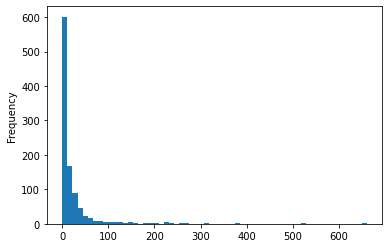

In [57]:
df_prior['lambda'].plot.hist(bins=60)
plt.show()

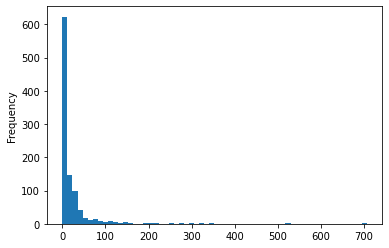

In [58]:
df_prior['child_mortality'].plot.hist(bins=60)
plt.show()

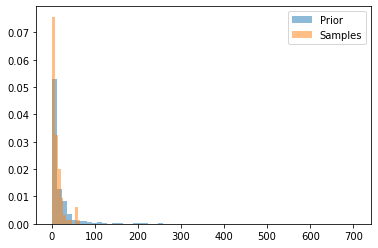

In [59]:
fig, ax = plt.subplots()
ax.hist(df_prior['child_mortality'], bins=60, alpha=0.5, density=True, label='Prior')
ax.hist(data["child_mortality"], bins=10, alpha=0.5, density=True, label='Samples')
ax.legend()
plt.show()

In [60]:
abs(df_prior['child_mortality'].mean() - data['child_mortality'].mean())

7.872163265306121

Although the visual analysis in the form of graphs and the average error are not ideal indicators of the quality of the obtained model, it can be concluded that it reflects the characteristics of the problem quite well. <br><br>

# POSTERIOR - FIRST MODEL

Posterior models use the same parameters already described in the previous section, but instead of representing the data as distributions, real data is used to fit the models.
<br><br>
There were no sampling issues with the model so below presented is usage of the model and the analysis of the obtained samples.

In [61]:
%%writefile posterior_1.stan

data {
  int N;  
  int child_mortality[N];  
  real co2_emission[N]; 
  real food_supply[N];  
  real med_beds[N];  
  real gender_equality[N];
}

parameters {
  real alpha; 
  real co2_emission_coef;
  real food_supply_coef; 
  real med_beds_coef; 
  real gender_equality_coef;
}

transformed parameters {
    real lambda[N];
    for (i in 1:N){
        lambda[i] = exp(alpha + co2_emission_coef * co2_emission[i] + food_supply_coef * food_supply[i] + med_beds_coef * med_beds[i] + gender_equality_coef * gender_equality[i]);  
    }
}

model {
  alpha ~ normal(2, 1);
  food_supply_coef ~ normal(0.5, 0.1);
  med_beds_coef ~ normal(0.5, 0.1);
  co2_emission_coef ~ normal(0.5, 0.1);
  gender_equality_coef ~ normal(0.5, 0.1); 

  for (i in 1:N){
      child_mortality[i] ~ poisson(lambda[i]);
  }
}

generated quantities {
  vector [N] log_lik;
  real predicted_child_mortality[N];
  for (i in 1:N) {
    log_lik[i] = poisson_lpmf(child_mortality[i] | lambda[i]);
    predicted_child_mortality[i] = poisson_rng(lambda[i]);
  }
}

Overwriting posterior_1.stan


In [62]:
model_1=CmdStanModel(stan_file='posterior_1.stan')

INFO:cmdstanpy:compiling stan file /home/Child-Mortality-Prediction-Model/posterior_1.stan to exe file /home/Child-Mortality-Prediction-Model/posterior_1
INFO:cmdstanpy:compiled model executable: /home/Child-Mortality-Prediction-Model/posterior_1
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Child-Mortality-Prediction-Model/posterior_1.hpp /home/Child-Mortality-Prediction-Model/posterior_1.stan
Warning in '/home/Child-Mortality-Prediction-Model/posterior_1.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Child-Mortality-Prediction-Model/posterior_1.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before th

In [63]:
fit_1=model_1.sample(data=dict(N=len(data), child_mortality=data.child_mortality.values, co2_emission=data.co2_emission.values, food_supply=data.food_supply.values, med_beds=data.med_beds.values, gender_equality=data.gender_equality.values), seed=20052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 2 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [64]:
df_fit_1 = fit_1.draws_pd()
df_fit_1

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,co2_emission_coef,food_supply_coef,...,predicted_child_mortality[89],predicted_child_mortality[90],predicted_child_mortality[91],predicted_child_mortality[92],predicted_child_mortality[93],predicted_child_mortality[94],predicted_child_mortality[95],predicted_child_mortality[96],predicted_child_mortality[97],predicted_child_mortality[98]
0,2178.65,0.902547,0.475989,2.0,7.0,0.0,-2176.99,2.29790,-0.128869,-0.345381,...,14.0,6.0,13.0,6.0,8.0,11.0,4.0,17.0,14.0,60.0
1,2179.53,0.915358,0.475989,3.0,7.0,0.0,-2177.56,2.29969,-0.109139,-0.335577,...,9.0,7.0,10.0,9.0,8.0,7.0,4.0,16.0,9.0,51.0
2,2179.48,0.993364,0.475989,3.0,7.0,0.0,-2178.39,2.33186,-0.107020,-0.314590,...,13.0,4.0,11.0,11.0,10.0,8.0,4.0,18.0,7.0,61.0
3,2178.61,0.956333,0.475989,3.0,7.0,0.0,-2176.11,2.26374,-0.143063,-0.278391,...,16.0,9.0,8.0,15.0,7.0,9.0,2.0,19.0,11.0,62.0
4,2174.67,0.408335,0.475989,2.0,7.0,0.0,-2170.90,2.26752,-0.134189,-0.352933,...,21.0,13.0,12.0,13.0,4.0,5.0,6.0,13.0,12.0,71.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2176.55,0.705515,0.398049,3.0,7.0,0.0,-2175.46,2.29152,-0.047793,-0.320502,...,18.0,6.0,8.0,5.0,11.0,11.0,6.0,5.0,15.0,67.0
3996,2179.82,0.982180,0.398049,2.0,7.0,0.0,-2175.22,2.28835,-0.051769,-0.328490,...,19.0,9.0,14.0,6.0,8.0,7.0,5.0,17.0,9.0,67.0
3997,2180.41,0.999926,0.398049,3.0,7.0,0.0,-2179.34,2.26662,-0.118604,-0.323219,...,10.0,5.0,8.0,4.0,8.0,7.0,5.0,10.0,14.0,71.0
3998,2180.72,0.981138,0.398049,3.0,7.0,0.0,-2179.92,2.26318,-0.085533,-0.317852,...,12.0,6.0,5.0,6.0,8.0,7.0,4.0,12.0,11.0,54.0


In [65]:
means = []
for i in range(1, 99):
    means.append(df_fit_1["predicted_child_mortality[" + str(i) + "]"].mean())

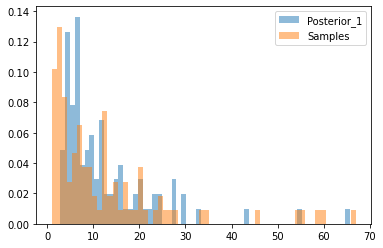

In [73]:
fig, ax = plt.subplots()
ax.hist(means, bins=60, alpha=0.5, density=True, label='Posterior_1')
ax.hist(data["child_mortality"], bins=60, alpha=0.5, density=True, label='Samples')
ax.legend()
plt.show()

In [69]:
abs(np.array(means).mean() - data['child_mortality'].mean())

0.009188775510207137

The average error value has decreased, but more importantly, when analyzing the histograms, we can see that the model fits the real data much better - for example, there are no values greater than 70 as it was in the prior model. <br>
Still, it's not a perfect representation and it's possible to get better results.


# POSTERIOR - SECOND MODEL

In the second model we specified, the single parameter alpha was replaced by a country-specific parameter alpha[i]. <br>
It was dane, by declaring alpha as an array of appropriate dimension. <br>
This chane was made because when using a single value for the parameter, the posterior distribution has difficulty in accurately reflecting the observed data. <br>
However, by entering individual values for each country, the model significantly improves its ability to fit the data.
<br><br>
There were no sampling issues with the model so below presented is usage of the model and the analysis of the obtained samples.

In [75]:
%%writefile posterior_2.stan

data {
  int N;  
  int child_mortality[N];  
  real co2_emission[N]; 
  real food_supply[N];  
  real med_beds[N];  
  real gender_equality[N];
}

parameters {
  real alpha[N]; 
  real co2_emission_coef;
  real food_supply_coef; 
  real med_beds_coef; 
  real gender_equality_coef;
}

transformed parameters {
    real lambda[N];
    for (i in 1:N){
        lambda[i] = exp(alpha[i] + co2_emission_coef * co2_emission[i] + food_supply_coef * food_supply[i] + med_beds_coef * med_beds[i] + gender_equality_coef * gender_equality[i]);  
    }
}

model {
  alpha ~ normal(2, 1);
  food_supply_coef ~ normal(0.5, 0.1);
  med_beds_coef ~ normal(0.5, 0.1);
  co2_emission_coef ~ normal(0.5, 0.1);
  gender_equality_coef ~ normal(0.5, 0.1); 

  for (i in 1:N){
      child_mortality[i] ~ poisson(lambda[i]);
  }
}

generated quantities {
  vector [N] log_lik;
  real predicted_child_mortality[N];
  for (i in 1:N) {
    log_lik[i] = poisson_lpmf(child_mortality[i] | lambda[i]);
    predicted_child_mortality[i] = poisson_rng(lambda[i]);
  }
}

Overwriting posterior_2.stan


In [76]:
model_2=CmdStanModel(stan_file='posterior_2.stan')

INFO:cmdstanpy:compiling stan file /home/Child-Mortality-Prediction-Model/posterior_2.stan to exe file /home/Child-Mortality-Prediction-Model/posterior_2
INFO:cmdstanpy:compiled model executable: /home/Child-Mortality-Prediction-Model/posterior_2
--- Translating Stan model to C++ code ---
bin/stanc  --o=/home/Child-Mortality-Prediction-Model/posterior_2.hpp /home/Child-Mortality-Prediction-Model/posterior_2.stan
Warning in '/home/Child-Mortality-Prediction-Model/posterior_2.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/home/Child-Mortality-Prediction-Model/posterior_2.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before th

In [77]:
fit_2=model_2.sample(data=dict(N=len(data), child_mortality=data.child_mortality.values, co2_emission=data.co2_emission.values, food_supply=data.food_supply.values, med_beds=data.med_beds.values, gender_equality=data.gender_equality.values), seed=20052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |▉         | 00:00 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |████▌     | 00:00 Iteration:  800 / 2000 [ 40%]  (Warmup)
chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |████████▋ | 00:01 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |█████████▌| 00:01 Iteration: 1800 / 2000 [ 90%]  (Sampling)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [81]:
df_fit_2 = fit_2.draws_pd()
df_fit_2

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha[1],alpha[2],alpha[3],...,predicted_child_mortality[89],predicted_child_mortality[90],predicted_child_mortality[91],predicted_child_mortality[92],predicted_child_mortality[93],predicted_child_mortality[94],predicted_child_mortality[95],predicted_child_mortality[96],predicted_child_mortality[97],predicted_child_mortality[98]
0,2293.15,0.886450,0.202506,4.0,15.0,0.0,-2249.80,3.39881,2.37061,1.283660,...,30.0,11.0,14.0,6.0,10.0,10.0,5.0,14.0,14.0,40.0
1,2306.79,0.866844,0.202506,4.0,15.0,0.0,-2241.35,3.83001,2.31217,1.950880,...,55.0,13.0,12.0,4.0,6.0,9.0,4.0,29.0,31.0,62.0
2,2300.06,0.908147,0.202506,4.0,31.0,0.0,-2258.07,4.39042,2.17417,1.486170,...,40.0,19.0,21.0,15.0,8.0,10.0,4.0,10.0,18.0,44.0
3,2305.08,0.874008,0.202506,4.0,15.0,0.0,-2249.89,4.30637,2.49166,0.924209,...,51.0,12.0,14.0,11.0,4.0,9.0,7.0,28.0,13.0,51.0
4,2311.19,0.978588,0.202506,4.0,15.0,0.0,-2267.29,4.41743,2.19884,2.023270,...,35.0,13.0,18.0,3.0,8.0,3.0,7.0,9.0,43.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2291.05,0.883582,0.182999,5.0,31.0,0.0,-2237.21,4.19292,1.85876,1.922150,...,38.0,17.0,19.0,3.0,12.0,1.0,9.0,20.0,23.0,32.0
3996,2305.29,0.974520,0.182999,4.0,31.0,0.0,-2250.16,4.15435,1.38465,1.957980,...,40.0,8.0,18.0,6.0,10.0,1.0,11.0,21.0,19.0,67.0
3997,2313.67,0.987344,0.182999,5.0,31.0,0.0,-2262.76,4.21270,1.93070,1.364490,...,40.0,14.0,7.0,8.0,8.0,7.0,5.0,22.0,21.0,70.0
3998,2314.06,0.804191,0.182999,5.0,31.0,0.0,-2262.26,3.92514,2.26325,2.266530,...,44.0,17.0,17.0,4.0,3.0,2.0,6.0,19.0,19.0,47.0


In [82]:
means = []
for i in range(1, 99):
    means.append(df_fit_2["predicted_child_mortality[" + str(i) + "]"].mean())

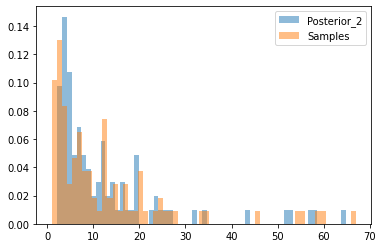

In [83]:
fig, ax = plt.subplots()
ax.hist(means, bins=60, alpha=0.5, density=True, label='Posterior_2')
ax.hist(data["child_mortality"], bins=60, alpha=0.5, density=True, label='Samples')
ax.legend()
plt.show()

In [85]:
abs(np.array(means).mean() - data['child_mortality'].mean())

0.08376275510203968

The histogram of this model is very similar to the previous one, while the average error value has even increased. However, as it was written earlier, these are not the best metrics for comparing predictive models, so the next chapter contains a more in-depth comparison.

# Model comparison

The following information criteria were used to compare the models:
- WAIC - evaluates the trade-off between model complexity and goodness of fit. It takes into account both the model's ability to explain the observed data (likelihood) and its complexity (number of parameters). The lower the WAIC value, the better the model's predictive performance
- PSIS-LOO - estimates how well a model generalizes to unseen data by evaluating its performance on leave-one-out cross-validation

In [86]:
compare_model_loo = az.compare(
    {
        "fit_1": az.from_cmdstanpy(fit_1),
        "fit_2": az.from_cmdstanpy(fit_2)
    },
    ic="loo",
    scale="deviance"
)

In [87]:
compare_model_waic = az.compare(
    {
        "fit_1": az.from_cmdstanpy(fit_1),
        "fit_2": az.from_cmdstanpy(fit_2)
    },
    ic="waic",
    scale="deviance"
)

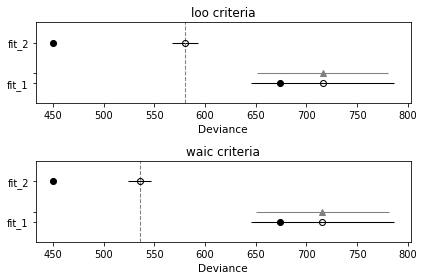

In [88]:
_, ax = plt.subplots(nrows=2, ncols=1)
az.plot_compare(compare_model_loo, insample_dev=True, ax=ax[0])
ax[0].set_title("loo criteria")
az.plot_compare(compare_model_waic, insample_dev=True, ax=ax[1])
ax[1].set_title("waic criteria")
plt.tight_layout()
plt.show()

In [89]:
print(compare_model_loo)

       rank         loo      p_loo       d_loo    weight         se       dse  \
fit_2     0  580.593691  65.287556    0.000000  0.563168  13.000617   0.00000   
fit_1     1  715.994919  21.109723  135.401228  0.436832  70.307725  65.01897   

       warning loo_scale  
fit_2     True  deviance  
fit_1     True  deviance  


In [90]:
print(compare_model_waic)

       rank        waic     p_waic      d_waic    weight         se  \
fit_2     0  535.592254  42.786838    0.000000  0.872062  11.157684   
fit_1     1  715.743322  20.983924  180.151068  0.127938  70.367374   

             dse  warning waic_scale  
fit_2   0.000000     True   deviance  
fit_1  65.550067     True   deviance  


Explanation and analysis of the obtained results:
- loo / waic - represents the estimated expected log predictive density for each model, lower values indicate better predictive performance - the second model obtained a better result for both criteria
- p_loo / p_waic - measures the number of parameters that contribute effectively to the model's ability to fit the data, lower values indicate a simpler model - the results indicate that the second model is more advanced 
- d_loo / d_waic - relative difference to the best model -  best is second model
- weight - higher weights indicate better model - second model won in this criterion
- se - represents the standard error of estimate for each model, larger standard errors indicate higher uncertainty in the estimates - here also the second model turns out to be better